In [14]:
import numpy as np
import scipy

import torch
from torch.utils.data import DataLoader

import librosa
from hyperparameters import *

from custom_datasets import EmbDataset
from preprocessing import melspectrogram, downsample_whiten

from utils import show, random_crop, get_X
import os

from IPython.display import Audio
from matplotlib import pyplot as plt
import seaborn as sns

from tqdm import tqdm_notebook as tqdm

from VGGish import vggish

from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

import warnings
import os
from sklearn.manifold import TSNE

import soundfile as sf


warnings.filterwarnings('ignore')
sns.set()

plt.rcParams['figure.figsize'] = 10, 7

In [9]:
path = os.path.join(TRAIN_DATA_PATH, '27', '123349', '27-123349-0005.flac')
audio, sr = sf.read(path)
show(audio)

### Vizualization of train data

No handles with labels found to put in legend.


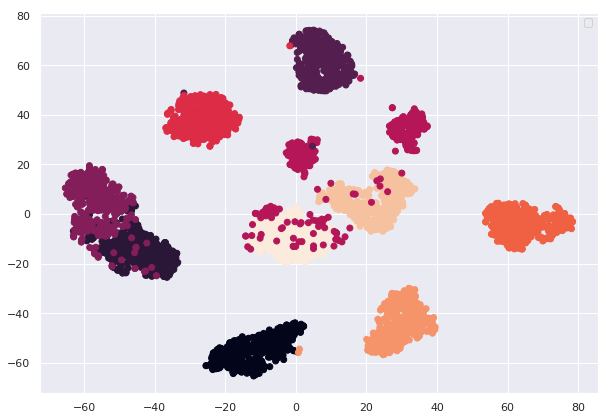

In [51]:
tmp_data = EmbDataset(EMB_DATA_PATH, 'train1', user_regexp='00[0-9]')
X, y = get_X(tmp_data)
X_embedded = TSNE(n_components=2).fit_transform(X)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y)
plt.legend()
plt.savefig('train_emb')

### Vizualization of test data

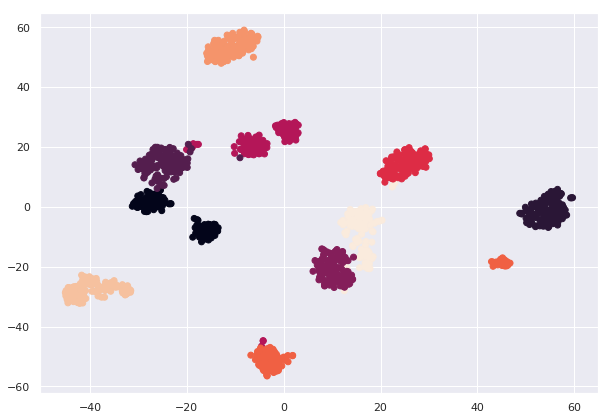

In [52]:
tmp_data = EmbDataset(EMB_DATA_PATH, 'train2', user_regexp='00[0-9]')
X, y = get_X(tmp_data)
X_embedded = TSNE(n_components=2).fit_transform(X)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y)
# plt.legend()
plt.savefig('test_emb')

In [24]:
train1_data = EmbDataset(EMB_DATA_PATH, 'train1')
train1_loader = DataLoader(train1_data, batch_size=64, num_workers=4)
val_data = EmbDataset(EMB_DATA_PATH, 'val')
val_loader = DataLoader(val_data, batch_size=64, num_workers=4)

train2_data = EmbDataset(EMB_DATA_PATH, 'train2')
train2_loader = DataLoader(train2_data, batch_size=64, num_workers=4)
test_data = EmbDataset(EMB_DATA_PATH, 'test')
test_loader = DataLoader(test_data, batch_size=64, num_workers=4)
len(train1_data), len(val_data), len(train2_data), len(test_data)

(39046, 9940, 5147, 1297)

### Classification using embedding only

In [27]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV


X, y = get_X(train1_data)
params = {'n_neighbors': [2, 3, 4, 5, 6, 7, 10, 15, 20]}
knn = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)
clf = GridSearchCV(knn, params, cv=3)
clf.fit(X, y)
clf.best_params_

{'n_neighbors': 7}

In [28]:
clf = KNeighborsClassifier(n_neighbors=7, n_jobs=-1)

X_train, y_train = get_X(train2_data)
X_test, y_test = get_X(test_data)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9444872783346183

### Classification using mean embedding only

In [50]:
clf = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)

X_raw, y_raw = get_X(train2_data)
X_train = []
y_train = []
for y in np.unique(y_raw):
    X_train.append(X_raw[y_raw==y].mean(axis=0))
    y_train.append(y)
X_train = np.stack(X_train)
y_train = np.array(y_train, dtype=int)
X_test, y_test = get_X(test_data)

clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.8334618350038551

### K-shot learning

In [54]:
X_train, y_train = get_X(train2_data)
X_test, y_test = get_X(test_data)
X_by_y = {}

for y in np.unique(y_train):
    X_by_y[y] = X_train[y_train==y]

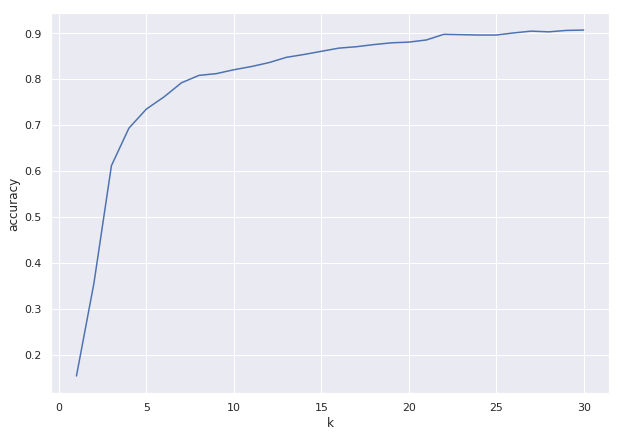

In [71]:
acc = []
ks = list(range(1, 31))
for k in ks:
    X_train = []
    y_train = []
    for y in X_by_y:
        z = X_by_y[y][:k]
        X_train.append(z)
        y_train.append([y] * len(z))
    y_train = np.concatenate(y_train)
    X_train = np.concatenate(X_train)
    clf = KNeighborsClassifier(n_neighbors=7, n_jobs=-1)
    clf.fit(X_train, y_train)
    acc.append(clf.score(X_test, y_test))
plt.plot(ks, acc)
plt.xlabel('k')
plt.ylabel('accuracy')
plt.savefig('k-shot')

### Training classifiers

In [30]:
X_train, y_train = get_X(train2_data)
params = {'n_neighbors': [2, 3, 4, 5, 6, 7, 10, 15, 20]}
knn = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)
clf = GridSearchCV(knn, params, cv=3)
clf.fit(X_train, y_train)
clf.score(X_test, y_test), clf.best_params_

(0.9421742482652274, {'n_neighbors': 6})

In [32]:
from sklearn.ensemble import RandomForestClassifier


params = {'max_depth': [5, 10, 15, 30, None], 'min_samples_leaf': [1, 2, 3, 5]}
rf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
clf = GridSearchCV(rf, params, cv=3)
clf.fit(X_train, y_train)
clf.score(X_test, y_test), clf.best_params_

(0.9313801079414032, {'max_depth': None, 'min_samples_leaf': 1})

In [39]:
from sklearn.ensemble import GradientBoostingClassifier

params = {'learning_rate': [1e-3, 5e-2, 0.1]}

gb = GradientBoostingClassifier(n_estimators=10)
clf = GridSearchCV(gb, params, cv=3)
clf.fit(X_train, y_train)
clf.score(X_test, y_test), clf.best_params_

(0.812644564379337, {'learning_rate': 0.1})

In [41]:
clf = GradientBoostingClassifier(n_estimators=300, learning_rate=0.1)
%time clf.fit(X_train, y_train)
clf.score(X_test, y_test)

CPU times: user 23min 48s, sys: 489 ms, total: 23min 49s
Wall time: 3min 58s


0.9121048573631457

### Classification task

In [ ]:
from collections import OrderedDict
import torch
import torch.nn as nn
from tensorboardX import SummaryWriter


class SimpleModel(nn.Module):
    def __init__(self, num_classes, input_size=512):
        super(self.__class__, self).__init__()
        
        self.backbone = vggish(include_classifier=False, pretrained=True)
        for p in self.backbone.parameters():
            p.requires_grad = False
        self.lin = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        x = self.backbone(x)
        x = x.view(len(x), -1)
        x = self.lin(x)
        return x

In [ ]:
def train(model, optimizer, criterion, train_loader, test_loader, device, n_epochs=N_EPOCHS, log_dir='./logs'):
    writer = SummaryWriter(log_dir)
    for epoch in tqdm(range(n_epochs)):
        model.train()
        train_loss = 0
        train_acc = 0
        k = 0
        elems = 0
        for i, (records, labels) in enumerate(train_loader):
            records = records.to(device)
            labels = labels.to(device).long()
            
            outputs = model(records)
            loss = criterion(outputs, labels)
            
            train_loss += loss.item()
            train_acc += (outputs.argmax(dim=1) == labels).sum().item()
            k += 1
            elems += len(labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_loss /= k
        train_acc /= elems
        
        model.eval()
        test_loss = 0
        test_acc = 0
        k = 0
        elems = 0
        for i, (records, labels) in enumerate(test_loader):
            records = records.to(device)
            labels = labels.to(device).long()
            
            with torch.no_grad():
                outputs = model(records)
                loss = criterion(outputs, labels)
            test_loss += loss.item()
            test_acc += (outputs.argmax(dim=1) == labels).sum().item()
            k += 1
            elems += len(labels)
        test_loss /= k
        test_acc /= elems
        
        writer.add_scalar('simple/train_loss', train_loss, epoch)
        writer.add_scalar('simple/train_acc', train_acc, epoch)
        writer.add_scalar('simple/test_loss', test_loss, epoch)
        writer.add_scalar('simple/test_acc', test_acc, epoch)

In [ ]:
batch_size = 64
lr = 1e-4
num_classes = 10

train_data = MelCelebDataset(MEL_DATA_PATH, 'train' , user_regexp='00[0-9]')
val_data = MelCelebDataset(MEL_DATA_PATH, 'val' , user_regexp='00[0-9]')
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=4)

model = SimpleModel(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
n_epochs = 100
train(model, optimizer, criterion, train_loader, val_loader, device, n_epochs=n_epochs)

In [ ]:
nom = 0
denom = 0
for i, (X, y) in enumerate(tqdm(train_loader)):
    X = X.to(device)
    y = y.to(device)
    with torch.no_grad():
        y_pred = model(X).view(len(X), -1)
        nom += (y_pred.argmax(dim=1) == y).sum()
        denom += len(y)
acc = nom.item() / denom